In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs6353/assignments/assignment2/'
FOLDERNAME = 'cs6353/assignments/assignment2/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs6353/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

# Install requirements from colab_requirements.txt
# TODO: Please change your path below to the colab_requirements.txt file
! python -m pip install -r /content/drive/My\ Drive/$FOLDERNAME/colab_requirements.txt

Mounted at /content/drive
/content/drive/My Drive/cs6353/assignments/assignment2/cs6353/datasets
--2024-12-06 20:32:12--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  39.5MB/s    in 4.5s    

2024-12-06 20:32:16 (36.2 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
/content/drive/My Drive/cs6353/assignments/assignment2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://utah.instructure.com/courses/919972/assignments/12590082) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [2]:

from __future__ import print_function
import random
import numpy as np
from cs6353.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [6]:
from cs6353.features import color_histogram_hsv, hog_feature
from cs6353.data_utils import load_CIFAR10

def get_CIFAR10_data(cifar10_dir='cs6353/datasets/cifar-10-batches-py', num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except NameError:
   pass

################################################################################
# TODO: Change the path of the CIFAR-10 data directory correctly to            #
# the correct location                                                         #
# Default path is set to cs6353/datasets/cifar-10-batches-py'                 #
################################################################################
cifar10_dir='cs6353/datasets/cifar-10-batches-py'

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(cifar10_dir)

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################



Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [23]:
from cs6353.features import *

num_color_bins = 20  # Increase the number of bins for better feature representation
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [38]:
# Use the validation set to tune the learning rate and regularization strength

from cs6353.classifiers.linear_classifier import LinearSVM

learning_rates = [5e-9, 6e-9, 6.5e-9, 7e-9, 7.5e-9, 8e-9]
regularization_strengths = [5.5e6, 6e6, 6.5e6, 6.75e6, 7e6, 7.5e6]

num_color_bins = 25  # Increased number of bins
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]

# Normalize features
mean_feat = np.mean(X_train_feats, axis=0)
std_feat = np.std(X_train_feats, axis=0)
X_train_feats = (X_train_feats - mean_feat) / (std_feat + 1e-6)
X_val_feats = (X_val_feats - mean_feat) / (std_feat + 1e-6)
X_test_feats = (X_test_feats - mean_feat) / (std_feat + 1e-6)

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifier in best_svm. You might also want to play         #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################



for lr in learning_rates:
    for reg in regularization_strengths:
        print(f"Training with lr={lr}, reg={reg}")

        svm = LinearSVM()
        loss_hist = svm.train(
            X_train_feats, y_train,
            learning_rate=lr,
            reg=reg,
            num_iters=10000,  # Increased iterations
            verbose=True  # Monitor progress
        )

        y_train_pred = svm.predict(X_train_feats)
        train_accuracy = np.mean(y_train_pred == y_train)
        y_val_pred = svm.predict(X_val_feats)
        val_accuracy = np.mean(y_val_pred == y_val)

        results[(lr, reg)] = (train_accuracy, val_accuracy)

        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm





################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

Training with lr=5e-09, reg=5500000.0
iteration 0 / 10000: loss 8852.123110
iteration 100 / 10000: loss 9.107898
iteration 200 / 10000: loss 8.999997
iteration 300 / 10000: loss 8.999997
iteration 400 / 10000: loss 8.999997
iteration 500 / 10000: loss 8.999997
iteration 600 / 10000: loss 8.999998
iteration 700 / 10000: loss 8.999997
iteration 800 / 10000: loss 8.999997
iteration 900 / 10000: loss 8.999996
iteration 1000 / 10000: loss 8.999997
iteration 1100 / 10000: loss 8.999997
iteration 1200 / 10000: loss 8.999997
iteration 1300 / 10000: loss 8.999996
iteration 1400 / 10000: loss 8.999996
iteration 1500 / 10000: loss 8.999997
iteration 1600 / 10000: loss 8.999997
iteration 1700 / 10000: loss 8.999996
iteration 1800 / 10000: loss 8.999997
iteration 1900 / 10000: loss 8.999997
iteration 2000 / 10000: loss 8.999997
iteration 2100 / 10000: loss 8.999996
iteration 2200 / 10000: loss 8.999997
iteration 2300 / 10000: loss 8.999997
iteration 2400 / 10000: loss 8.999997
iteration 2500 / 1000

In [39]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.433


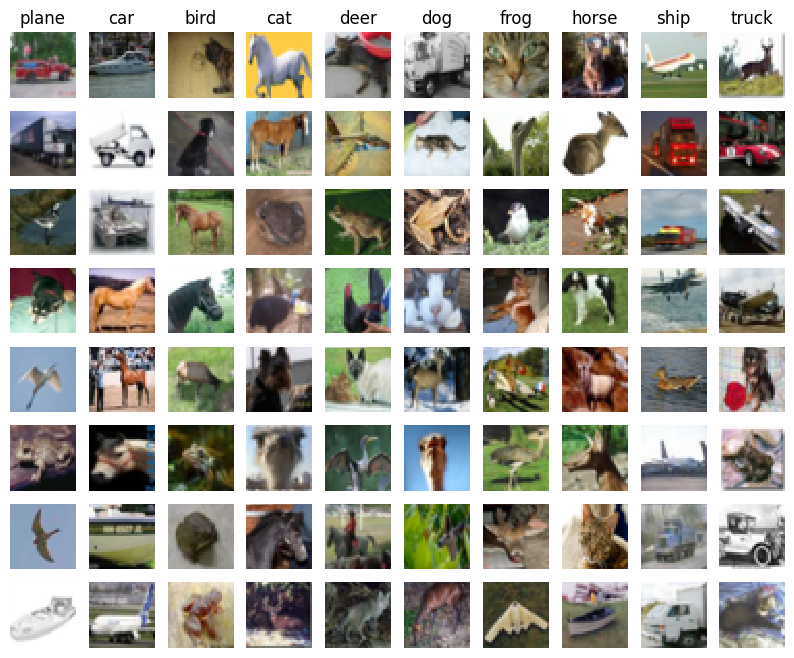

In [40]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

When visualizing the misclassification results, we observe that the classifier often makes mistakes in ways that seem intuitive and are explainable based on visual and feature-level similarities between certain classes in the CIFAR-10 dataset. Let's break down the misclassifications for each class:

1. Planes (Predicted but Incorrect)
  Misclassified images often include "birds" and "ships."
  Reason: Planes and birds share similar sky-colored backgrounds or smooth outlines, while planes and ships can both be large objects in open environments.
  Does this make sense? Yes. Both "planes" and "birds" might have been confused due to feature overlaps in smooth gradients and edges. Similarly, "planes" and "ships" could have overlapping geometric shapes or colors in certain instances.

2. Cars (Predicted but Incorrect)

  Misclassified images often include "trucks."
  Reason: Cars and trucks have very similar structural features such as wheels, rectangular shapes, and colors.
  Does this make sense? Absolutely. The classifier may fail to differentiate subtle differences, such as the larger size or cargo area of a truck, especially since both share significant overlapping visual characteristics.


3. Birds (Predicted but Incorrect)
  Misclassified images include "planes" and "deer."
  Reason: Birds and planes may share visual similarities in smooth curves, wings, and backgrounds with open skies. Similarly, "birds" and "deer" could be confused in cases where the texture and backgrounds (e.g., trees, grass) look similar.
  Does this make sense? Yes, particularly for bird-plane confusion, as both are seen in similar environmental contexts (sky backgrounds).

4. Cats (Predicted but Incorrect)
  Misclassified images include "dogs" and "horses."
  Reason: Cats and dogs share similar textures (fur) and may have similar poses or backgrounds. Cats and horses could be confused when the background textures (e.g., grass or barns) dominate the feature extraction process.
  Does this make sense? Yes. Both cats and dogs are visually similar, and misclassifications between these two classes are common.

5. Deer (Predicted but Incorrect)
  Misclassified images include "horses" and "dogs."
  Reason: Deer and horses often appear in similar natural settings (fields, forests) and have similar body structures. Dogs might be confused due to certain poses or textures, such as fur or background similarity.
  Does this make sense? Yes, since their body shapes and environments overlap.

6. Dogs (Predicted but Incorrect)
  Misclassified images include "cats" and "horses."
  Reason: Dogs and cats share similar textures and features, while dogs and horses could be confused due to overlapping backgrounds and body orientations.
  Does this make sense? Yes, the feature overlap between furry animals or their environments contributes to this confusion.

7. Frogs (Predicted but Incorrect)
  Misclassified images include "cats" and "deer."
  Reason: Frogs could be confused with animals found in natural settings (e.g., "deer") due to similar environmental contexts, while "cats" might be due to poses or unclear feature extraction.
  Does this make sense? Yes, particularly in the case of misclassification with other natural or textured objects.

8. Horses (Predicted but Incorrect)
  Misclassified images include "deer" and "dogs."
  Reason: Horses and deer share similar body shapes, while horses and dogs may be confused due to visual poses or background similarities.
  Does this make sense? Yes, because animals with similar shapes and environments are harder to distinguish.

9. Ships (Predicted but Incorrect)
  Misclassified images include "planes" and "cars."
  Reason: Ships and planes share large smooth surfaces or open environment contexts (water vs. sky). Ships and cars might be confused due to rectangular structures or similar lighting.
  Does this make sense? Yes, since these classes share some common visual features.

10. Trucks (Predicted but Incorrect)
  Misclassified images include "cars."
  Reason: Trucks and cars are visually similar, and their differences (e.g., size, cargo) may not be well captured by the features.
  Does this make sense? Yes, given that both classes share a significant feature overlap.




## Neural Network on image features
Earlier in this assignment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels.

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [44]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 163)
(49000, 162)


Training with lr=0.01, reg=0.0005
iteration 0 / 20000: loss 2.302586
iteration 100 / 20000: loss 2.302877
iteration 200 / 20000: loss 2.302793
iteration 300 / 20000: loss 2.302779
iteration 400 / 20000: loss 2.302004
iteration 500 / 20000: loss 2.302591
iteration 600 / 20000: loss 2.302275
iteration 700 / 20000: loss 2.302148
iteration 800 / 20000: loss 2.301900
iteration 900 / 20000: loss 2.301194
iteration 1000 / 20000: loss 2.301067
iteration 1100 / 20000: loss 2.299259
iteration 1200 / 20000: loss 2.296211
iteration 1300 / 20000: loss 2.282430
iteration 1400 / 20000: loss 2.277762
iteration 1500 / 20000: loss 2.261511
iteration 1600 / 20000: loss 2.205863
iteration 1700 / 20000: loss 2.111349
iteration 1800 / 20000: loss 2.115461
iteration 1900 / 20000: loss 2.074275
iteration 2000 / 20000: loss 2.031121
iteration 2100 / 20000: loss 2.068694
iteration 2200 / 20000: loss 1.902971
iteration 2300 / 20000: loss 1.910992
iteration 2400 / 20000: loss 1.876333
iteration 2500 / 20000: loss

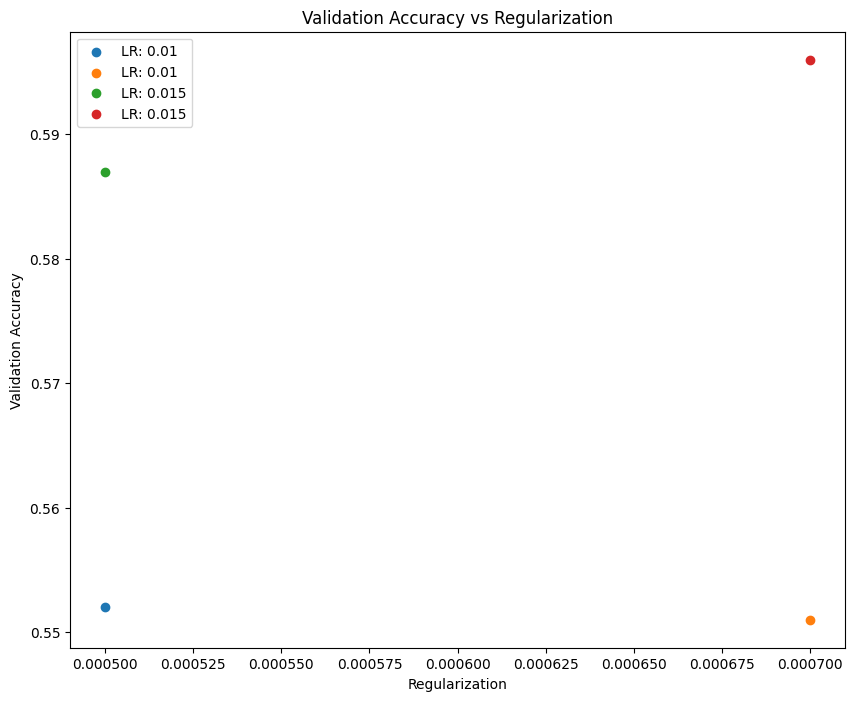

Test accuracy: 0.5570


In [47]:
from cs6353.classifiers.neural_net import TwoLayerNet


################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################

# Define the network parameters
input_dim = X_train_feats.shape[1]
hidden_dim = 1000  # Increased hidden layer size
num_classes = 10
learning_rates = [1e-2, 1.5e-2]  # Refined learning rates
regularization_strengths = [5e-4, 7e-4]  # Refined regularization strengths
batch_size = 128  # Smaller batch size
num_iters = 20000  # Increased iterations

# Initialize variables to track the best network and validation accuracy
best_net = None
best_val_acc = -1
results = {}

# Perform cross-validation
for lr in learning_rates:
    for reg in regularization_strengths:
        print(f"Training with lr={lr}, reg={reg}")

        # Initialize a new TwoLayerNet
        net = TwoLayerNet(input_dim, hidden_dim, num_classes)

        # Train the network
        stats = net.train(
            X_train_feats, y_train,
            X_val_feats, y_val,
            num_iters=num_iters,
            batch_size=batch_size,
            learning_rate=lr,
            learning_rate_decay=0.98,  # Slower decay
            reg=reg,
            verbose=True
        )

        # Evaluate the validation accuracy
        val_acc = (net.predict(X_val_feats) == y_val).mean()
        train_acc = (net.predict(X_train_feats) == y_train).mean()
        print(f"Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")

        # Store results
        results[(lr, reg)] = (train_acc, val_acc)

        # Update the best network if validation accuracy improves
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_net = net

print(f"Best validation accuracy: {best_val_acc:.4f}")

# Visualize results
import matplotlib.pyplot as plt
for (lr, reg), (train_acc, val_acc) in results.items():
    plt.scatter(reg, val_acc, label=f"LR: {lr}")
plt.xlabel("Regularization")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.title("Validation Accuracy vs Regularization")
plt.show()

# Evaluate the best network on the test set
test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(f"Test accuracy: {test_acc:.4f}")




################################################################################
#                              END OF YOUR CODE                                #
################################################################################

In [48]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.557


In [51]:
!pip install nbconvert
!apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package texlive-generic-recommended


In [56]:
from google.colab import files

!jupyter nbconvert features.ipynb --to html


[NbConvertApp] Converting notebook features.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 955928 bytes to features.html
